# Neural Network V0.1 for Organic IR Spectroscopy

## Processing data

In [1]:
# Imports

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss


In [2]:
data = torch.load('ir_spectroscopy_dataset.pt')
X_values = data['X_values']
Y_values = data['Y_values']
Labels = data['Labels']


def preprocess_data(X_values, Y_values, Labels, cut_front=10, cut_end=10):
    """
    .pt file -> X_values, Y_values, Labels
    """
    # Trim the front and end of each spectrum
    processed_X = X_values[cut_front:-cut_end]
    processed_Y = Y_values[:, cut_front:-cut_end]

    # Create a mask for non-NaN rows and rows that are not all NaN
    mask = ~torch.isnan(processed_Y).all(dim=1) & ~torch.isnan(processed_Y).any(dim=1)

    # Apply the mask to Y_values and Labels
    processed_Y = processed_Y[mask]
    processed_Labels = Labels[mask]

    return processed_X, processed_Y, processed_Labels

# Example usage:
processed_X_values, processed_Y_values, processed_Labels = preprocess_data(X_values, Y_values, Labels)
print(f"Original X shape: {X_values.shape}, Processed X shape: {processed_X_values.shape}")
print(f"Original Y shape: {Y_values.shape}, Processed Y shape: {processed_Y_values.shape}")
print(f"Original labels: {Labels.shape}, Processed labels: {processed_Labels.shape}")



Original X shape: torch.Size([1000]), Processed X shape: torch.Size([980])
Original Y shape: torch.Size([141, 1000]), Processed Y shape: torch.Size([139, 980])
Original labels: torch.Size([141, 24]), Processed labels: torch.Size([139, 24])


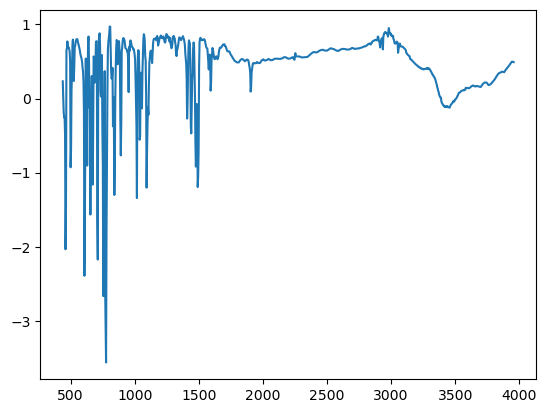

In [3]:
plt.plot(processed_X_values, processed_Y_values[2])

In [4]:
"""
Get Examples where label vectors are (LD) with others!! and make a test set out of them.
"""


def select_diverse_examples(processed_Y_values, processed_Labels, num_examples=10):
    num_samples = processed_Y_values.shape[0]
    num_labels = processed_Labels.shape[1]

    # Convert Labels to numpy for easier manipulation
    labels_np = processed_Labels.cpu().numpy()

    selected_indices = []
    remaining_indices = list(range(num_samples))

    while len(selected_indices) < num_examples and remaining_indices:
        if not selected_indices:
            # Select the first example randomly
            idx = np.random.choice(remaining_indices)
        else:
            # Calculate the Hamming distance to already selected examples
            distances = []
            for idx in remaining_indices:
                dist = [np.sum(labels_np[idx] != labels_np[sel_idx]) for sel_idx in selected_indices]
                distances.append(np.mean(dist))

            # Select the example with distance closest to the average
            avg_dist = np.mean(distances)
            idx = min(remaining_indices, key=lambda i: abs(distances[remaining_indices.index(i)] - avg_dist))

        selected_indices.append(idx)
        remaining_indices.remove(idx)

    # Create test set
    Y_test = processed_Y_values[selected_indices]
    Labels_test = processed_Labels[selected_indices]

    # Create train set (all indices not in selected_indices)
    train_indices = list(set(range(num_samples)) - set(selected_indices))
    Y_train = processed_Y_values[train_indices]
    Labels_train = processed_Labels[train_indices]

    return Y_train, Labels_train, Y_test, Labels_test

# Use the function to split the dataset
Y_train, Labels_train, Y_test, Labels_test = select_diverse_examples(processed_Y_values, processed_Labels)

# Training Set: Indices 0 to 399

print(f"Training set shape: {Y_train.shape}")
print(f"Training labels shape: {Labels_train.shape}")
print(f"Test set shape: {Y_test.shape}")
print(f"Test labels shape: {Labels_test.shape}")

# Verify that we have diverse examples in the test set
print("\nUnique label combinations in test set:")
for i in range(len(Labels_test)):
    print(f"Example {i+1}: {Labels_test[i].nonzero().squeeze().tolist()}")

Training set shape: torch.Size([129, 980])
Training labels shape: torch.Size([129, 24])
Test set shape: torch.Size([10, 980])
Test labels shape: torch.Size([10, 24])

Unique label combinations in test set:
Example 1: [0, 7, 11, 13, 23]
Example 2: 0
Example 3: [7, 8, 23]
Example 4: [6, 7, 13, 23]
Example 5: [7, 8, 11]
Example 6: [7, 11, 16]
Example 7: [0, 6, 7, 8, 23]
Example 8: 13
Example 9: [0, 6]
Example 10: [7, 10, 23]


# NN 

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Linear(out_features, out_features),
            nn.BatchNorm1d(out_features)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x + self.layer(x))

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(980, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            ResidualBlock(512, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),      # Added linear layer
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 24)        # Updated final layer to follow the new layer
            # No activation here since BCEWithLogitsLoss includes sigmoid
        )
        print(f"The NN has: {sum(p.numel() for p in self.parameters())} parameters")

    def forward(self, Y_values):
        out = self.layers(Y_values)
        return out


In [6]:

# Create TensorDatasets
train_dataset = TensorDataset(Y_train, Labels_train)
test_dataset = TensorDataset(Y_test, Labels_test)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = NN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the GPU
model = model.to(device)

# Move data tensors to GPU
Labels_train = Labels_train.to(device)
Y_train = Y_train.to(device)
Labels_test = Labels_test.to(device)
Y_test = Y_test.to(device)

print("Model and data moved to GPU successfully.")

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

# Define Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                               factor=0.1, patience=20, verbose=True)


The NN has: 1205592 parameters
Using device: cuda
Model and data moved to GPU successfully.


/usr/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [7]:

#----// Training Loop //---------------------------

optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0)

num_epochs = 1000  # Set a maximum number of epochs
best_loss = float('inf')
patience = 100  # Number of epochs to wait for improvement before early stopping
no_improve = 0
epoch = 0

#for epoch in range(num_epochs):
while True:
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    outputs = model(Y_train)
    loss = criterion(outputs, Labels_train)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    if loss.item() < 0.01:
        print("Reached Stop Point!!")
        print(f"Converged after {epoch+1} epochs.")
        break

    epoch += 1

print(f"Training completed. Final loss: {loss.item()}")


Epoch 1, Loss: 0.7135486006736755
Epoch 2, Loss: 0.7090002298355103
Epoch 3, Loss: 0.7137523889541626
Epoch 4, Loss: 0.7095444202423096
Epoch 5, Loss: 0.7172839641571045
Epoch 6, Loss: 0.7124723792076111
Epoch 7, Loss: 0.7076766490936279
Epoch 8, Loss: 0.7134434580802917
Epoch 9, Loss: 0.7127495408058167
Epoch 10, Loss: 0.7122389674186707
Epoch 11, Loss: 0.716179609298706
Epoch 12, Loss: 0.7122846841812134
Epoch 13, Loss: 0.7157567143440247
Epoch 14, Loss: 0.7065475583076477
Epoch 15, Loss: 0.7111884951591492
Epoch 16, Loss: 0.7087715864181519
Epoch 17, Loss: 0.7088456153869629
Epoch 18, Loss: 0.7090685963630676
Epoch 19, Loss: 0.7116761803627014
Epoch 20, Loss: 0.7099589109420776
Epoch 21, Loss: 0.7131416201591492
Epoch 22, Loss: 0.7082648873329163
Epoch 23, Loss: 0.7136889696121216
Epoch 24, Loss: 0.7117636203765869
Epoch 25, Loss: 0.70625239610672
Epoch 26, Loss: 0.7088598012924194
Epoch 27, Loss: 0.709868848323822
Epoch 28, Loss: 0.7102399468421936
Epoch 29, Loss: 0.709754288196563

In [8]:
def get_indices_above_threshold(vector, threshold):
    return [i for i, value in enumerate(vector) if value > threshold]

# Modified inference
model.eval()  # Set the model to evaluation mode
threshold = 0.5  # Increased threshold for more confident predictions

with torch.no_grad():  # Disable gradient calculation
    for i in range(10):  # Process 10 examples
        model_output = model(Y_test[i].unsqueeze(0)).squeeze()  # Add batch dimension and then remove it
        indices_above_threshold = get_indices_above_threshold(model_output, threshold)
        correct = get_indices_above_threshold(Labels_test[i], threshold)

        print(f"Example {i+1}:")
        print("Indices Predicted:", indices_above_threshold)
        print("Actual Indices:", correct)
        print()  # Add a blank line between examples for readability


Example 1:
Indices Predicted: [23]
Actual Indices: [0, 7, 11, 13, 23]

Example 2:
Indices Predicted: [10, 23]
Actual Indices: [0]

Example 3:
Indices Predicted: [23]
Actual Indices: [7, 8, 23]

Example 4:
Indices Predicted: [7, 23]
Actual Indices: [6, 7, 13, 23]

Example 5:
Indices Predicted: [6, 23]
Actual Indices: [7, 8, 11]

Example 6:
Indices Predicted: [6, 7, 11, 23]
Actual Indices: [7, 11, 16]

Example 7:
Indices Predicted: [7, 8]
Actual Indices: [0, 6, 7, 8, 23]

Example 8:
Indices Predicted: [0, 7, 23]
Actual Indices: [13]

Example 9:
Indices Predicted: [1, 6, 23]
Actual Indices: [0, 6]

Example 10:
Indices Predicted: [7, 23]
Actual Indices: [7, 10, 23]



In [9]:
def evaluate_model_accuracy(model, X_values, y_true, threshold=0.5):
    model.eval()
    total_correct = 0
    total_predicted = 0
    total_actual = 0

    with torch.no_grad():
        for i in range(len(X_values)):
            model_output = model(X_values[i].unsqueeze(0)).squeeze()
            predicted_indices = set(get_indices_above_threshold(model_output, threshold))
            actual_indices = set(get_indices_above_threshold(y_true[i], threshold))

            correct = predicted_indices.intersection(actual_indices)
            total_correct += len(correct)
            total_predicted += len(predicted_indices)
            total_actual += len(actual_indices)

    precision = total_correct / total_predicted if total_predicted > 0 else 0
    recall = total_correct / total_actual if total_actual > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}(Positive guesses/inverse Proportional to false positive rate)")
    print(f"Recall: {recall:.4f} (Negative Guesses/Inverse Proportional to false negative rate.)")
    print(f"F1 Score: {f1_score:.4f}(total performance!)")

    return precision, recall, f1_score

# Usage
precision, recall, f1_score = evaluate_model_accuracy(model, Y_test, Labels_test)

Precision: 0.5000(Positive guesses/inverse Proportional to false positive rate)
Recall: 0.3667 (Negative Guesses/Inverse Proportional to false negative rate.)
F1 Score: 0.4231(total performance!)


# DocTools

layer 0: mean -0.00, std 0.36
layer 1: mean -0.03, std 1.38
layer 2: mean 0.53, std 0.75
layer 3: mean -0.71, std 0.78
layer 4: mean -0.55, std 1.17
layer 5: mean 0.26, std 0.57
layer 6: mean -0.09, std 0.41
layer 7: mean -0.15, std 1.04
layer 8: mean 0.70, std 1.04
layer 9: mean 0.70, std 1.04
layer 10: mean -1.12, std 1.44
layer 11: mean -0.21, std 1.02
layer 12: mean 0.33, std 0.72
layer 13: mean -0.52, std 0.94
layer 14: mean 0.12, std 0.98
layer 15: mean 0.45, std 0.76
layer 16: mean -0.61, std 1.02
layer 17: mean 0.08, std 1.40
layer 18: mean 0.60, std 1.10
layer 19: mean -6.24, std 4.61


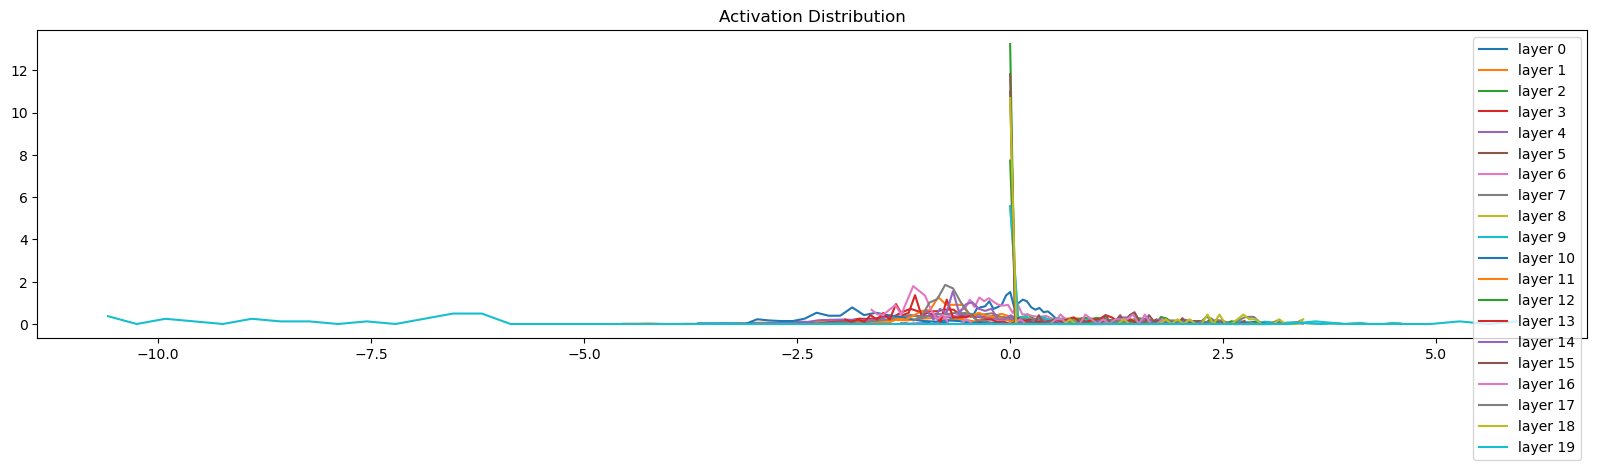

In [16]:
# DocTools

import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_activations(model, input_data):
    model.eval()
    activations = []
    
    def hook(module, input, output):
        activations.append(output.detach())
    
    # Register hooks for each layer
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Linear, torch.nn.BatchNorm1d, torch.nn.ReLU)):
            hooks.append(module.register_forward_hook(hook))
    
    # Forward pass
    with torch.no_grad():
        model(input_data)
    
    # Remove hooks
    for h in hooks:
        h.remove()
    
    # Visualize histograms
    plt.figure(figsize=(20, 4))
    legends = []
    
    for i, activation in enumerate(activations):
        if activation.dim() > 2:
            activation = activation.view(activation.size(0), -1)
        
        t = activation.view(-1).cpu().numpy()
        print(f'layer {i}: mean {np.mean(t):.2f}, std {np.std(t):.2f}')
        
        hist, bin_edges = np.histogram(t, bins=50, density=True)
        plt.plot(bin_edges[:-1], hist)
        legends.append(f'layer {i}')
    
    plt.legend(legends)
    plt.title('Activation Distribution')
    plt.show()

# Usage
# Assuming you have your model and a sample input
sample_input = Y_train[:1]  # Use the first training sample
visualize_activations(model, sample_input)

layer 0 (layers.0.weight): mean 0.000091, std 1.598676e-03
layer 1 (layers.0.bias): mean -0.000000, std 1.097774e-10
layer 2 (layers.1.weight): mean -0.000001, std 1.114154e-04
layer 3 (layers.1.bias): mean 0.000008, std 2.598247e-04
layer 4 (layers.4.layer.0.weight): mean -0.000001, std 1.219683e-04
layer 5 (layers.4.layer.0.bias): mean 0.000000, std 3.152642e-11
layer 6 (layers.4.layer.1.weight): mean -0.000000, std 1.368507e-04
layer 7 (layers.4.layer.1.bias): mean -0.000001, std 1.130390e-04
layer 8 (layers.4.layer.3.weight): mean 0.000002, std 1.279832e-04
layer 9 (layers.4.layer.3.bias): mean -0.000000, std 1.854259e-11
layer 10 (layers.4.layer.4.weight): mean 0.000001, std 5.858887e-05
layer 11 (layers.4.layer.4.bias): mean 0.000001, std 5.754487e-05
layer 12 (layers.7.weight): mean -0.000000, std 1.169667e-04
layer 13 (layers.7.bias): mean -0.000000, std 9.953370e-12
layer 14 (layers.8.weight): mean 0.000001, std 1.281833e-04
layer 15 (layers.8.bias): mean 0.000009, std 1.29267

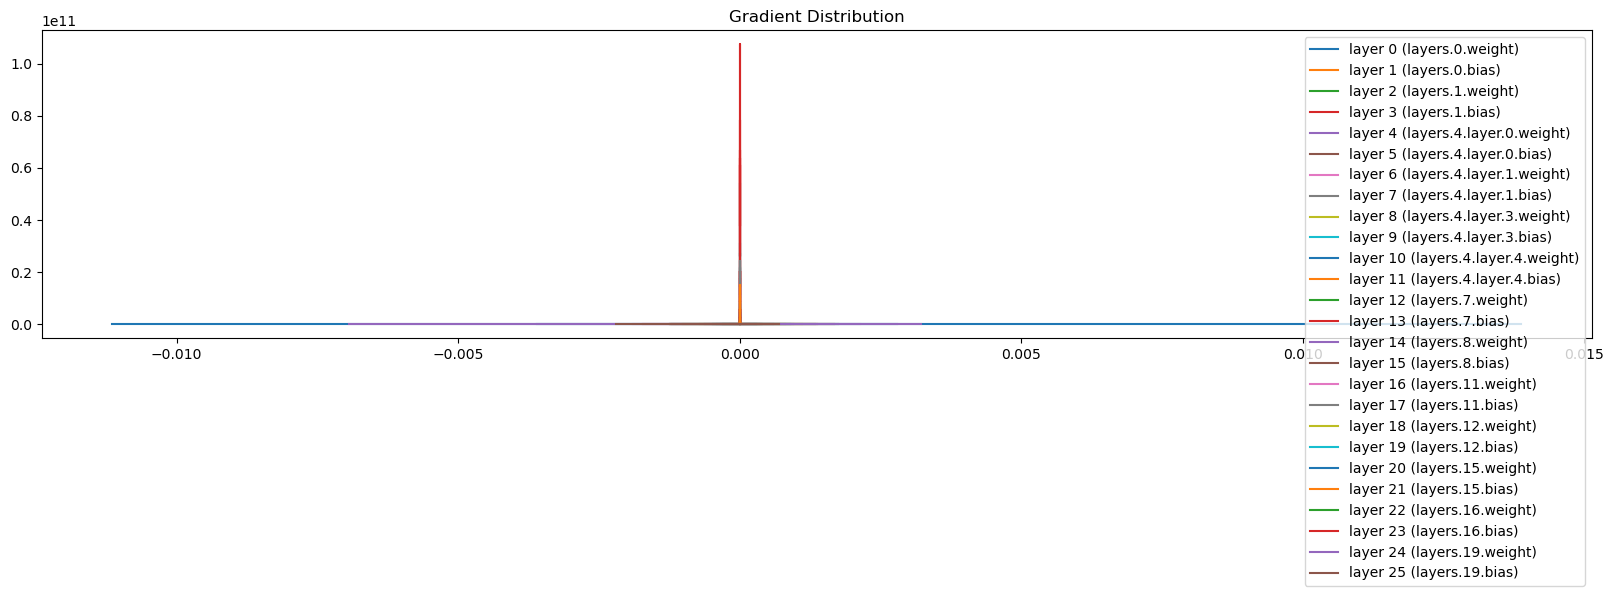

In [18]:
def visualize_gradients(model, criterion, input_data, labels):
    model.train()  # Set model to training mode
    model.zero_grad()  # Clear previous gradients
    
    # Forward pass
    outputs = model(input_data)
    loss = criterion(outputs, labels)
    
    # Backward pass
    loss.backward()
    
    plt.figure(figsize=(20, 4))  # width and height of the plot
    legends = []
    
    for i, (name, param) in enumerate(model.named_parameters()):
        if param.grad is not None:
            t = param.grad.cpu().detach().numpy()  # Move to CPU and convert to numpy
            print(f'layer {i} ({name}): mean {np.mean(t):.6f}, std {np.std(t):.6e}')
            hist, bin_edges = np.histogram(t.flatten(), bins=50, density=True)
            plt.plot(bin_edges[:-1], hist)
            legends.append(f'layer {i} ({name})')
    
    plt.legend(legends)
    plt.title('Gradient Distribution')
    plt.show()

# Usage
# Assuming you have your model, criterion, and sample input/labels
sample_input = Y_train[:32]  # Use a batch of training samples
sample_labels = Labels_train[:32]
criterion = nn.BCEWithLogitsLoss()  # Make sure this matches your loss function

visualize_gradients(model, criterion, sample_input, sample_labels)

# Testing on Real Data!!

In [ ]:
def get_indices_above_threshold(vector, threshold):
    return (vector > threshold).nonzero(as_tuple=True)[0].cpu().numpy()

def process_example(model, device, threshold=0.5):
    """
    Processes the example.pt file using the provided model.
    """
    # Load the example data
    example = torch.load('example.pt', weights_only=True)  # Add weights_only=True to address the warning
    y_example = example[:, 1]  # Shape: (980,)

    # Convert to float32 and move tensor to the specified device
    y_example = y_example.to(device).float()

    # Reshape y_example to match the model's expected input
    y_example = y_example.unsqueeze(0)  # Shape: (1, 980)

    with torch.no_grad():
        model_output = model(y_example)
        indices_above_threshold = get_indices_above_threshold(model_output.squeeze(), threshold)
        print("Indices Predicted:", indices_above_threshold)


process_example(nn_model, device)

NameError: name 'nn_model' is not defined

# Saving the model!!

In [ ]:
# Export the model for future training
torch.save({
    'model_state_dict': nn_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item()
}, 'ir_model_checkpoint_(4L)_(L2)_v1.pth')

print("Model saved successfully for future training.")


Model saved successfully for future training.


In [ ]:
# Assuming you have defined your model architecture (nn_model) beforehand

# Load the checkpoint
checkpoint = torch.load('ir_model_checkpoint_(4L)_(L2)_v1.pth')

# Load the model state dictionary
nn_model.load_state_dict(checkpoint['model_state_dict'])

# If you want to continue training, you can also load the optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set the model to evaluation mode if you're using it for inference
#nn_model.eval()

print("Model loaded successfully.")

<ipython-input-10-2989b3f7ce80>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('ir_model_checkpoint_(4L)_(L2)_v1.pth')


Model loaded successfully.
